In [53]:
import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram, fcluster

In [56]:
class AgglomerativeClustering():
    def __init__(self, metric='euclidean', linkage='single'):
        metric_choices = {
            'euclidean': lambda a, b: np.sqrt(((a-b) ** 2).sum()),
            'precomputed': None
        }
        try:
            metric_func = metric_choices[metric]
        except KeyError as e:
            raise ValueError(
                f"Unknown metric."
            ) from e
        self._metric_func = metric_func

        def compute_ward_dist(a, b):
            c = np.concatenate(( a, b ))
            ward_dist = metric_func(c, c.mean(0)) ** 2 \
                - metric_func(b, b.mean(0)) ** 2 \
                - metric_func(a, a.mean(0)) ** 2
            return ward_dist
        linkage_choices = {
            'single': lambda a, b: np.minimum(a, b),
            'average': lambda a, b: (a+b)/2,
            'complete': lambda a, b: np.maximum(a, b),
            'ward': compute_ward_dist
        }
        try:
            join_func = linkage_choices[linkage]
        except KeyError as e:
            raise ValueError(
                f"Unknown linkage. Should be one of {linkage_choices.keys()}"
            ) from e
        if linkage == 'ward' and metric != 'euclidean':
            raise ValueError(
                f"Only euclidean disance is availible for ward's method."
            )
        self._join_func = join_func

        self.distance_matrix = None

    def __compute_distance_matrix(self, X):
        N = X.shape[0]
        matrix = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                dist = self._metric_func(X[i], X[j])
                matrix[i,j] = dist
        self.distance_matrix = matrix

    def fit(self, X):
        if self._metric_func != None:
            self.__compute_distance_matrix(X)
        else:
            self.distance_matrix = X
        
        agglomerative_schedule = []

        D = self.distance_matrix.copy()
        N = D.shape[0]
        vertex_index = N
        cluster_mapping = np.arange(N, dtype=int)

        mask = np.zeros_like(D)
        D_masked = ma.masked_array(D, mask)
        D_masked.fill_value = np.inf
        np.fill_diagonal(D_masked.mask, 1)

        for k in range(N-1):
            ind_min_flat = np.argmin(D_masked)
            ind_min = np.unravel_index(ind_min_flat, D_masked.shape)
            i, j = ind_min
            a = D[:, i].copy()
            b = D[:, j].copy()
            new_cluster = self._join_func(a, b)
            
            agglomerative_schedule.append((i+1, j+1,
                D_masked[ind_min].copy()))

            D_masked[:, [j]] = ma.masked
            D_masked[[j], :] = ma.masked
            D_masked.data[:, [i]] = np.atleast_2d(new_cluster).T
            D_masked.data[[i], :] = new_cluster
        self.agglomerative_schedule =  agglomerative_schedule

In [57]:
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

X1 = pd.read_excel('data/clustering.xlsx', sheet_name='raw_data')
X1

,x1,x2
0,1,5
1,7,9
2,1,3
3,9,7


In [59]:
data_to_cluster = pd.read_csv("data/clustering-data-structure-volume.csv")
data_to_cluster.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",1.27e+07,0.34,0.33,0.13,0.06
1,B,Добыча полезных ископаемых,4.20e+07,0.07,0.19,0.70,0.03
2,C,Обрабатывающие производства,4.01e+07,0.22,0.50,0.23,0.03
3,D,"Обеспечение электрической энергией, газом и па...",2.93e+07,0.16,0.34,0.46,0.01
4,E,"Водоснабжение; водоотведение, организация сбор...",5.52e+06,0.12,0.11,0.71,0.04


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'distance_threshold'

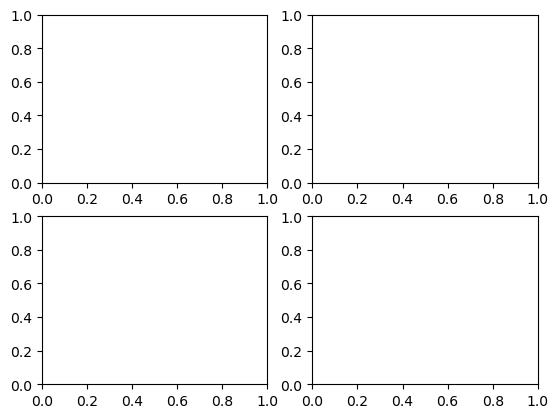

In [60]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

feature_labels_assets = ["Здания", "Машины и оборудование", \
    "Сооружения", "Транспортные средства"]
X = data_to_cluster.loc[:, feature_labels_assets]

linkage_types = ['ward', 'complete', 'average', 'single']
cutoff_thresholds = [0.55, 0.5, 0.38, 0.25]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = [' Уорда', 'Полной связи', "Средней связи", "Ближнего соседа"]
linkage_labels = dict(zip(linkage_types, labels))

mpl.rcParams.update(mpl.rcParamsDefault)
hclust = dict()
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type, distance_threshold=0, n_clusters=None)
    clustering = model.fit(X)
    axs[axs_ind].set_title(linkage_labels[linkage_type])
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        clustering,
        truncate_mode="level",
        p=3,
        ax=axs[axs_ind], 
        labels=data_to_cluster["Код раздела"].to_list(),
        color_threshold = linkage_colors[linkage_type]
        # orientation='right'
        )
    
    hclust[linkage_type] = {
        "clustering": clustering,
        "linkage_matrix": linkage_matrix
    }
fig.tight_layout()
plt.show()


In [52]:
model = AgglomerativeClustering(linkage='ward')
model.fit(X1.to_numpy())
print(*model.agglomerative_schedule, sep='\n')

(1, 3, 2.0)
(1, 2, 0.4862160718316275)
(1, 4, 12.14027664890245)


In [48]:
X2 = pd.read_excel('data/clustering.xlsx', sheet_name='dist_matrix', header=None)
X2

,0,1,2,3,4
0,0.0,2.2,3.0,5.1,5.8
1,2.2,0.0,1.4,5.0,6.4
2,3.0,1.4,0.0,6.4,7.8
3,5.1,5.0,6.4,0.0,2.0
4,5.8,6.4,7.8,2.0,0.0


In [43]:
model = AgglomerativeClustering(metric='precomputed')
model.fit(X2.to_numpy())
print(*model.agglomerative_schedule, sep='\n')

(2, 3, 1.4)
(4, 5, 2.0)
(1, 2, 2.2)
(1, 4, 5.0)
